In [386]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt
import seaborn as sns 
from scipy import stats
plt.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import ast
import scipy.stats as stats

#### NOTES 
- *GOAL* explore the dataset, analyze the underlying trends, and come up with some possible factors that lead to the customer success (subscription!) AND also the possible factors that prevent them from upgrading to a paid subscription (A report that visually displays your findings, the trends, and your reasonings)

- What’s the limitation of the data set?
    - One big limitation I am noticing off the bat is the number of null values especially in bantScore and onboarding stage, which I think are important features. 
- What additional data points do you think that can be added to this study? Why?

  We want to look at the relationships between bantscore, onboarding_stage, and planlevel
  bantScore and onboarding_stage should have a strong relationship because the bant score is calculated based off of answers to questions in the onboarding process

  In an effort to work around the presence of null values I am going to create a few different dataframes, one without bantScore entirely, one without any nulls from all features, and tbd

  Plan level is our target column. We want that to be as high as possible, So we want to find out what influences that the most.
  line chart showing the change in subscriptions over time 

  correlation between Plan level and onboarding stage?
  correlation between Plan level and num_sub_users?
  correlation between Plan level and Bant Score?
  correlation between Plan level and time spent?
  Are the any other important correlations we should know about?
  Find out who spends most time on Opensponsorship, to determine whether it is better to market toward COOs, or employees (dont treat as time spent on sight, but rather to show how little time is spent)

  My intuition tells me that onboarding stage and planLevel are highly correlated

  dataframes:
  all data with no nulls (approx. 1137 rows)
  data minus bantscore with no nulls (approx. 2136 rows)
  dataframes with columns with nulls dropped if the columns are not important. This will enable us to drill down of features that are more important than others. the first two dataframe allow us to still check those less important features.


  company size is ordinal
  country, role, and top_industry is nominal 
  

In [387]:
# Loading data and making index brand_id column
df = pd.read_csv('data/sample_brands_data.csv', index_col = 0)

# Checking shape of raw data
print(df.shape)

# Viewing first 5 rows of data
df.head()

(5839, 10)


,created,lastActive,planLevel,num_sub_user,role,industry_categories,bantScore,companySize,onboarding_stage,country
brand_id,,,,,,,,,,
1,2021-08-31 19:18:40,2021-08-31 19:20:38,0,1,brand,[],NaN,NaN,NaN,NaN
2,2020-08-28 4:38:11,2021-01-07 21:10:32,0,1,brand,[],NaN,NaN,4.0,United States
3,2020-08-21 13:55:13,2020-10-28 12:53:31,0,1,brand,[],NaN,NaN,4.0,NaN
4,2021-07-01 16:46:16,2021-07-01 16:46:59,0,1,founder,[],NaN,NaN,2.0,United States
5,2019-12-02 21:57:51,2019-12-20 17:35:41,0,1,brand,[],NaN,NaN,4.0,India


## PreProcessing

In [388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5839 entries, 1 to 5839
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   created              5839 non-null   object 
 1   lastActive           5831 non-null   object 
 2   planLevel            5839 non-null   int64  
 3   num_sub_user         5839 non-null   int64  
 4   role                 5833 non-null   object 
 5   industry_categories  5816 non-null   object 
 6   bantScore            1295 non-null   float64
 7   companySize          2406 non-null   object 
 8   onboarding_stage     5600 non-null   float64
 9   country              4835 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 501.8+ KB


In [389]:
df['planLevel'].value_counts()

planLevel
0    5774
3      29
9      18
2      10
1       8
Name: count, dtype: int64

In [390]:
df.duplicated().sum()

0

In [391]:
df.isnull().sum()

created                   0
lastActive                8
planLevel                 0
num_sub_user              0
role                      6
industry_categories      23
bantScore              4544
companySize            3433
onboarding_stage        239
country                1004
dtype: int64

<Axes: ylabel='brand_id'>

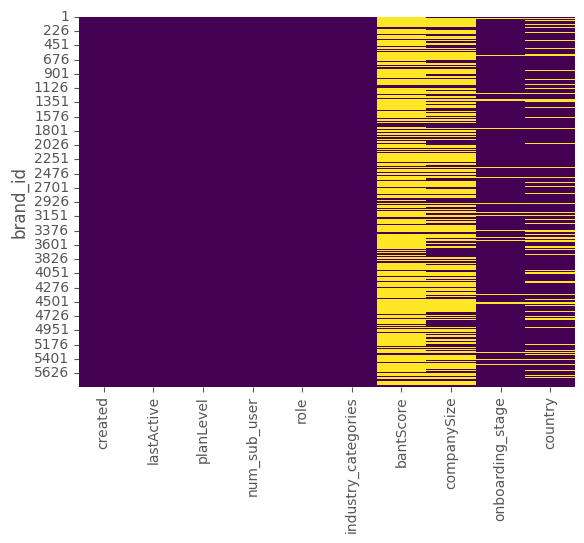

In [392]:
# Visualizing null values 
sns.heatmap(df.isnull(), cbar = False, cmap = 'viridis')

In [393]:
# In an effort to retain a good number of data points I am going to drop the bantScore feature and then drop Nulls, this gives use an extra ~1000 data points 
# We can analyze bant score seperately later

# Df for analyzing comapnySize with the most data
df_total = df
df_total = df_total.drop(['bantScore'], axis = 1)
df_total = df_total.dropna()

# Df for everything except bantScore and companySize
df_no_bant = df
df_no_bant = df_no_bant.drop(['bantScore', 'companySize'], axis = 1) 
df_no_bant = df_no_bant.dropna()
df_no_bant.shape

(4810, 8)

In [394]:
df_no_bant['onboarding_stage'].value_counts()

onboarding_stage
4.0    4178
2.0     281
0.0     233
3.0     115
1.0       3
Name: count, dtype: int64

In [395]:
# Correcting data types
df_no_bant['created'] = pd.to_datetime(df_no_bant['created'])
df_no_bant['lastActive'] = pd.to_datetime(df_no_bant['lastActive'])

df_no_bant['onboarding_stage'] = df_no_bant['onboarding_stage'].astype(int)
df_no_bant['industry_categories'] = df_no_bant['industry_categories'].apply(ast.literal_eval)

df_total['created'] = pd.to_datetime(df_total['created'])
df_total['lastActive'] = pd.to_datetime(df_total['lastActive'])

df_total['onboarding_stage'] = df_total['onboarding_stage'].astype(int)
df_total['industry_categories'] = df_total['industry_categories'].apply(ast.literal_eval)

### Feature Engineering

In [396]:
# Creating an hours spent since creation feature
df_no_bant['time_spent'] = df_no_bant.apply(lambda row: 
                                   (row['lastActive'] - row['created']).total_seconds() / 3600
                                   ,axis=1)

df_total['time_spent'] = df_total.apply(lambda row: 
                                   (row['lastActive'] - row['created']).total_seconds() / 3600
                                   ,axis=1)
df_no_bant.head(5)

,created,lastActive,planLevel,num_sub_user,role,industry_categories,onboarding_stage,country,time_spent
brand_id,,,,,,,,,
2,2020-08-28 04:38:11,2021-01-07 21:10:32,0,1,brand,[],4,United States,3184.539167
4,2021-07-01 16:46:16,2021-07-01 16:46:59,0,1,founder,[],2,United States,0.011944
5,2019-12-02 21:57:51,2019-12-20 17:35:41,0,1,brand,[],4,India,427.630556
6,2020-08-03 03:04:54,2020-08-03 03:18:42,0,1,brand,[],4,United States,0.230000
7,2020-07-27 02:45:34,2020-07-27 02:46:36,0,1,brand,[],4,United States,0.017222


In [397]:
# I am going to assume that the industry_categories is in order of most important industry

# Function to extract the first industry
def first_industry(lst):
    if isinstance(lst, list) and len(lst) > 0:
        return lst[0]
    else:
        return 'Unknown'

# Applying the function to both dataframes
df_no_bant['top_industry'] = df_no_bant['industry_categories'].apply(first_industry)
df_total['top_industry'] = df_total['industry_categories'].apply(first_industry)
df_no_bant.head(5)


,created,lastActive,planLevel,num_sub_user,role,industry_categories,onboarding_stage,country,time_spent,top_industry
brand_id,,,,,,,,,,
2,2020-08-28 04:38:11,2021-01-07 21:10:32,0,1,brand,[],4,United States,3184.539167,Unknown
4,2021-07-01 16:46:16,2021-07-01 16:46:59,0,1,founder,[],2,United States,0.011944,Unknown
5,2019-12-02 21:57:51,2019-12-20 17:35:41,0,1,brand,[],4,India,427.630556,Unknown
6,2020-08-03 03:04:54,2020-08-03 03:18:42,0,1,brand,[],4,United States,0.230000,Unknown
7,2020-07-27 02:45:34,2020-07-27 02:46:36,0,1,brand,[],4,United States,0.017222,Unknown


## EDA

### Univariate analysis 

#### Categorical Variables

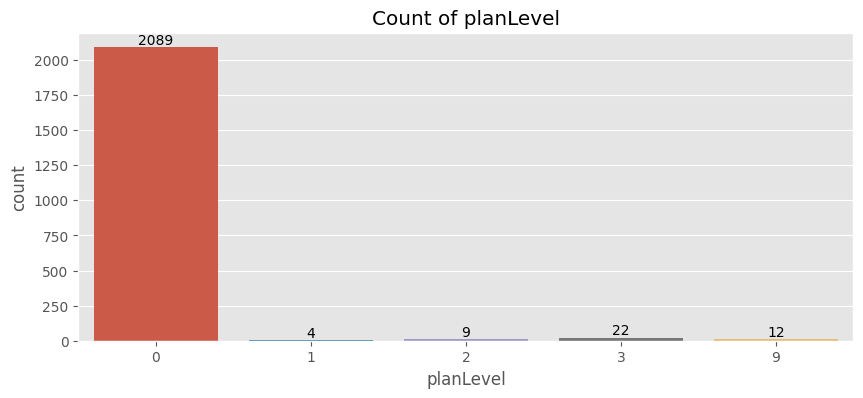

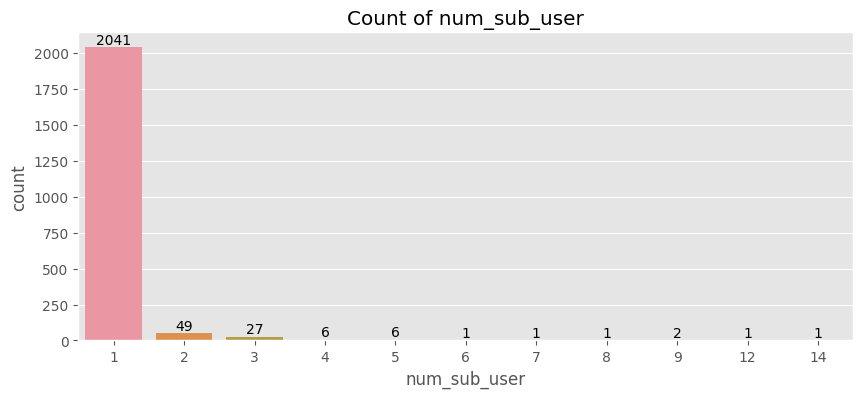

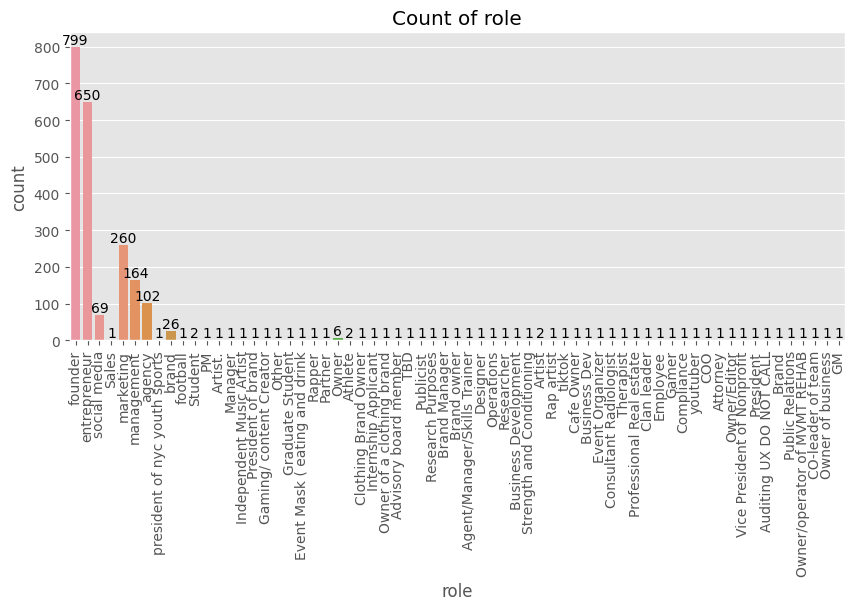

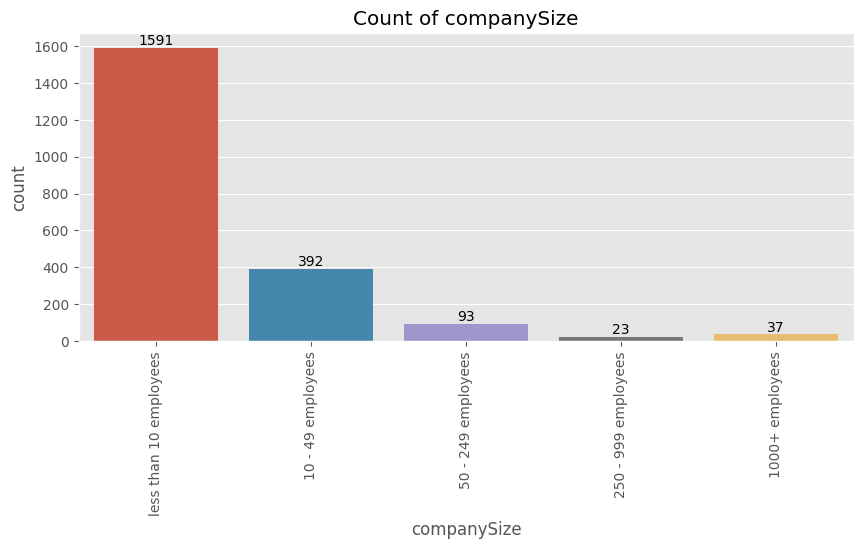

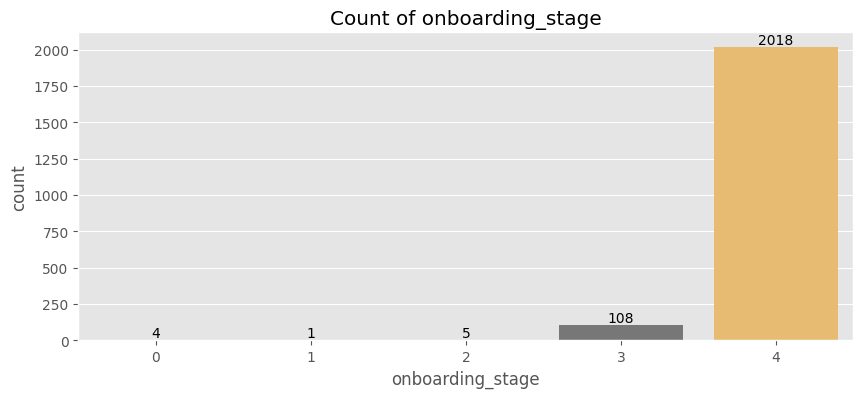

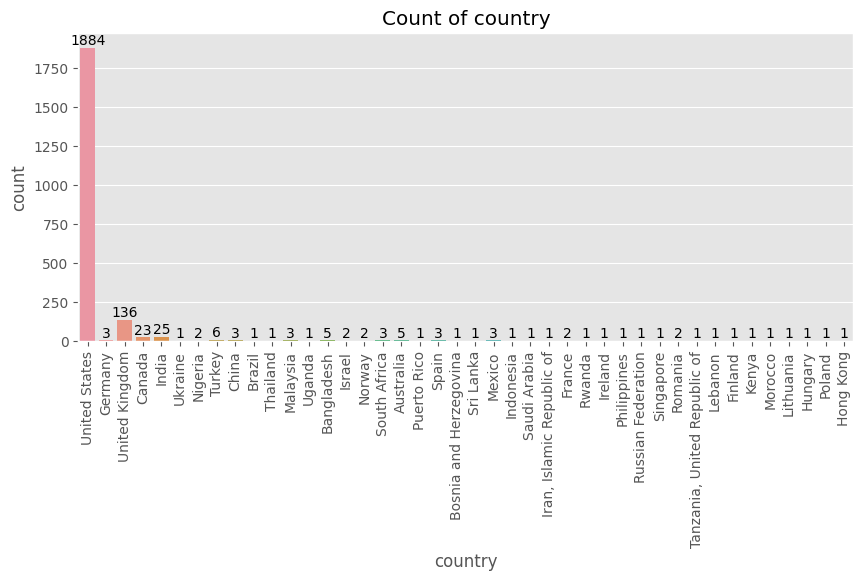

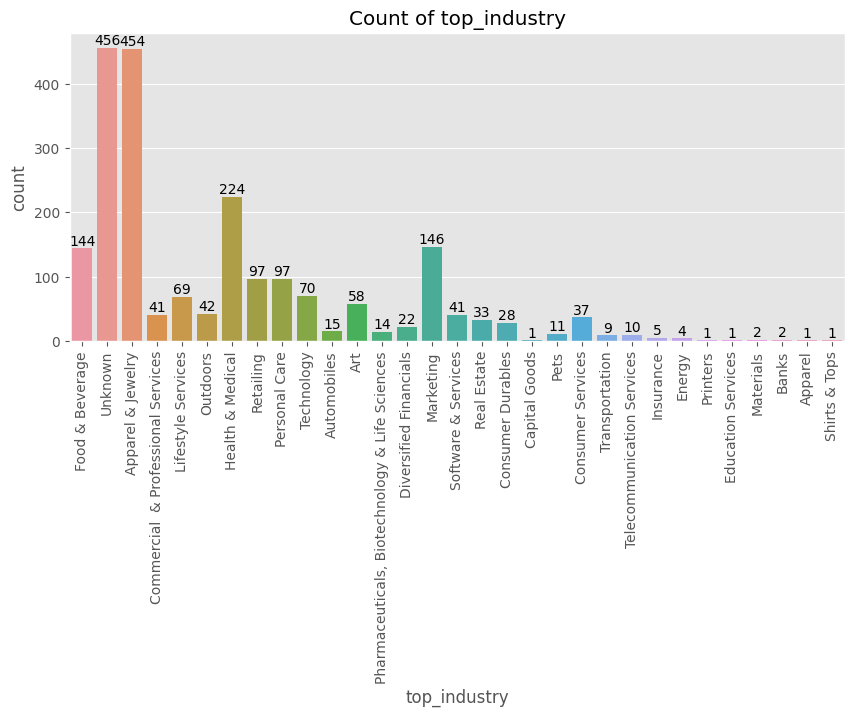

In [398]:
# Visualizations for all categorical variables
categorical_features = ['planLevel', 'num_sub_user', 'role', 'companySize', 'onboarding_stage', 'country', 'top_industry']

# Using for loop to generate bar charts for each categorical feature
for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    ax = sns.countplot(data=df_total, x=feature)
    plt.title('Count of ' + feature)

    rotate_xticks = any(len(str(tick.get_text())) > 5 for tick in ax.get_xticklabels())
    
    # Set rotation for x-axis ticks if category has length greater than 5 
    if rotate_xticks:
        plt.xticks(rotation=90)

    # Add count labels on top of the bars
    for p in ax.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10, color='black')
    

    plt.show()

#### Interpretation of results 
- **Plan Level**: As we can see the distribution of plan level is highly imbalanced. This will cause problems with later analysis.
- **Num Sub User**: The majority of users only have one sub-user.
- **Role**: This shows the two highest roles are founder and entrepreneur. Most likely this tells us that the brand is a smaller company.
- **Company Size**: Majority of companies have less than 10 employees
- **Onboarding Stage**: Most companies complete the onboarding process and make it to stage 4
- **Country**: United States and the UK are the two most common countries that our users are based in.
- **Top Industry**: There are a good number of different industries that use this platform, the most notable are Apparel & Jewelry, and Health & Medical.

#### Numeric Variables

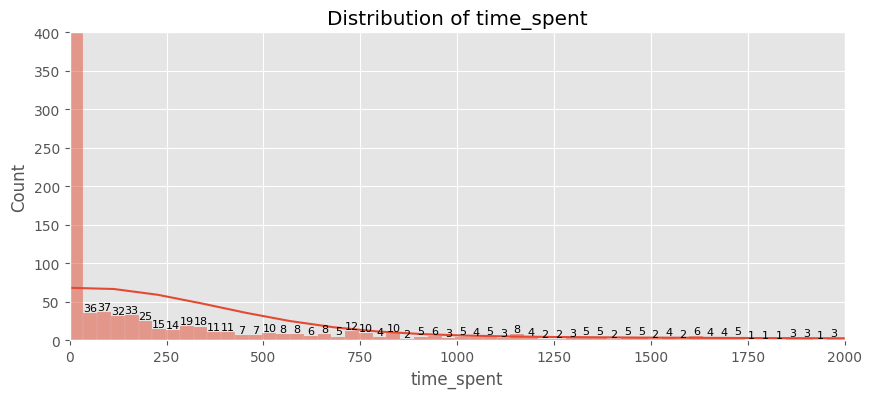

In [399]:
# Extremely skewed to the right indicating most users dont spend much to on the platform 
plt.figure(figsize=(10, 4))

# Plotting histogram of time spent
ax = sns.histplot(data=df_total, x='time_spent', kde=True)
plt.xlim(0, 2000)  
plt.ylim(0, 400)
plt.title('Distribution of time_spent')

# Plotting labels for the bars 
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=8, color='black')
        
plt.show()

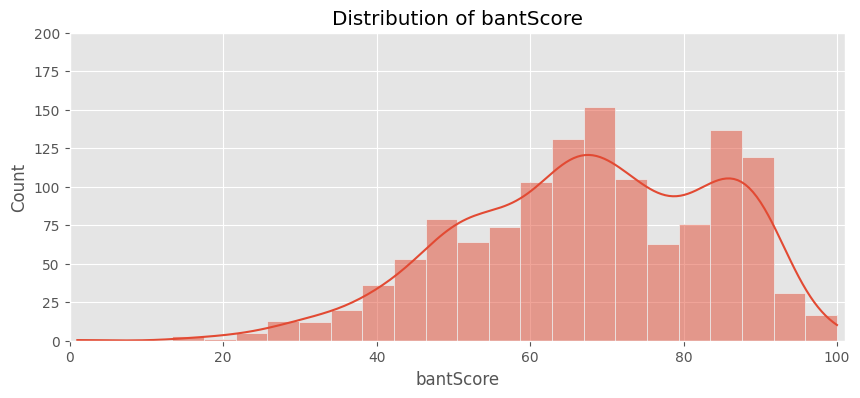

In [400]:
 # Bi-modal distribution slightly skewed to the right 
bant_df = df[['bantScore', 'planLevel']].dropna()

plt.figure(figsize=(10, 4))

# Plotting histogram of bantScore
sns.histplot(data=df, x='bantScore', kde=True, bins = 24)

plt.xlim(0, 101)  
plt.ylim(0, 200)

plt.title('Distribution of bantScore')
plt.show()

### Bivariate Analysis

#### Categorical variables

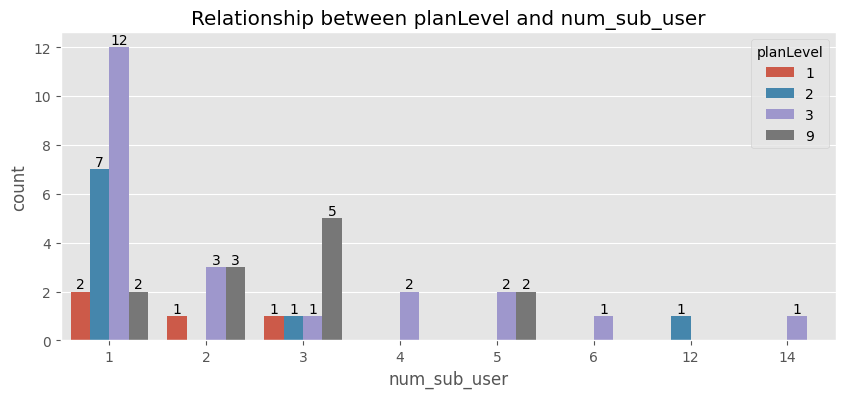

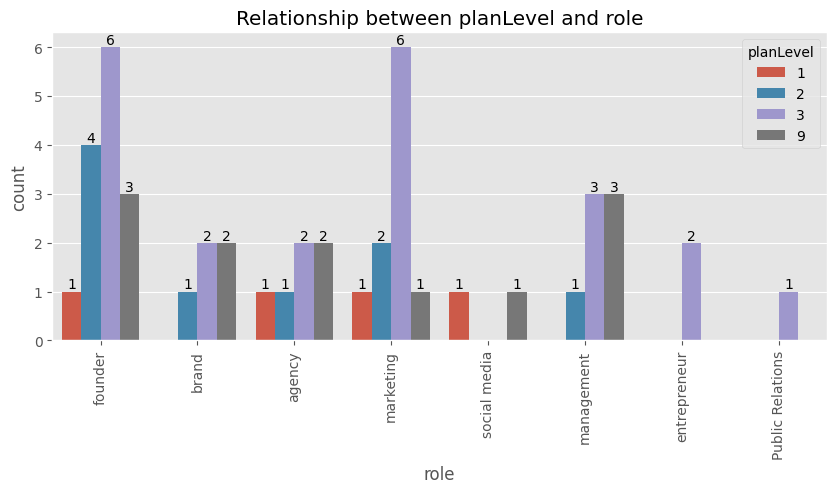

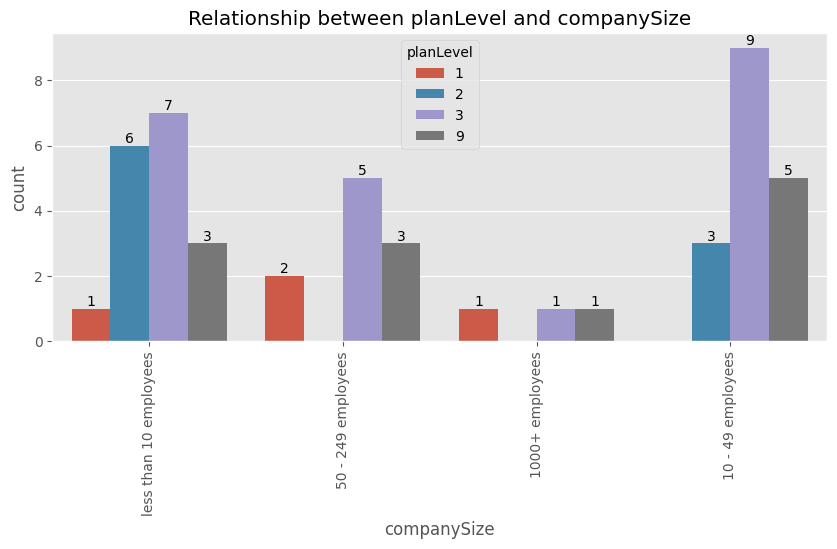

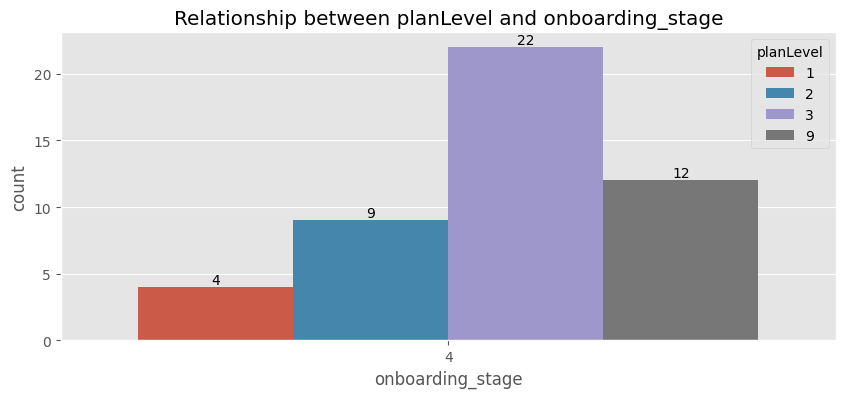

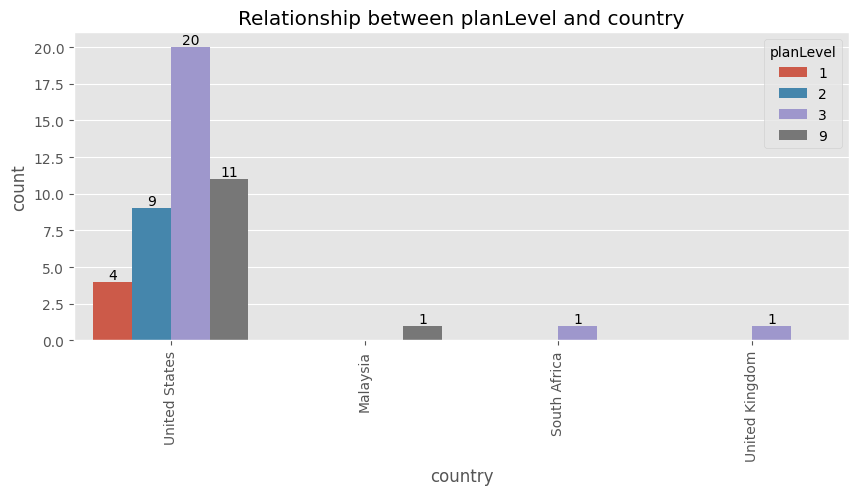

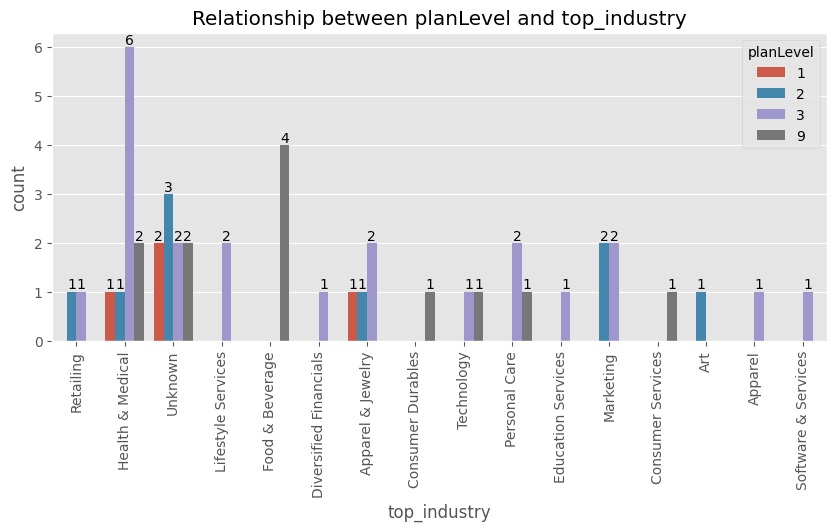

In [401]:
# Creating bar charts to look at distributions based on plan level except where plan level is 0 
# I am dropping planLevel 0 to drill down on the other planLevels, as when we include planLevel 0 it skews the data 
target_var = ['planLevel']
other_vars = ['num_sub_user', 'role', 'companySize', 'onboarding_stage', 'country', 'top_industry']
df_no_zero_plan = df_total[df_total['planLevel'] != 0]

for var1 in target_var:
    for var2 in other_vars:
        plt.figure(figsize=(10,4))
        ax = sns.countplot(data=df_no_zero_plan, x = var2, hue = var1)
        plt.title('Relationship between ' + var1 + ' and ' + var2)

        rotate_xticks = any(len(str(tick.get_text())) > 5 for tick in ax.get_xticklabels())
        
        # Set rotation for x-axis ticks if category has length greater than 5 
        if rotate_xticks:
            plt.xticks(rotation=90)
            
        # Add count labels on top of the bars
        for p in ax.patches:
            height = int(p.get_height())
            if height > 0:
                ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10, color='black')

        plt.show()

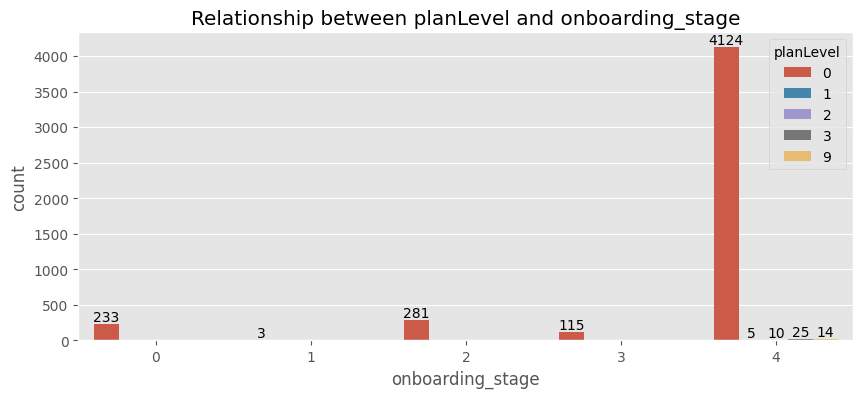

In [402]:
# planeLevel and onboarding_stage including planlevel 0 
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df_no_bant, x = 'onboarding_stage', hue = 'planLevel')
plt.title('Relationship between planLevel and onboarding_stage')

# Add count labels on top of the bars
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10, color='black')

plt.show()

#### Interpretation of results 
- **Plan Level and Num Sub User**: Majority of the data is taken up by plan level 0. when we look at only the paid plan levels we can see that companies with 1 sub user are more often subscribed to plan level 2 and 3, and companies with 3 sub users are most often subscribed to plan level 9.
- **Plan Level and Role**: The role that is most subscribed to each plan level is the founder role. Marketing toward founders might prove to increase subscription rates.
- **Plan Level and Company Size**: For plan level 3 and 9 a company size of 10-49 is most common. For plan level 2 it is less than 10 employees.
- **Plan Level and Onboarding Stage** As we can see the only users that didnt complete the onboarding stages are ones that do not have a paid subscription. Plan level 3 has completed the most onboarding stages right behind plan level 0.
- **Plan Level and Top Industry**: The industry with the most plan level 9 subscriptions is food and beverage. The industry with the most plan level 3 subscriptions was Health & Medical 

#### Numeric values

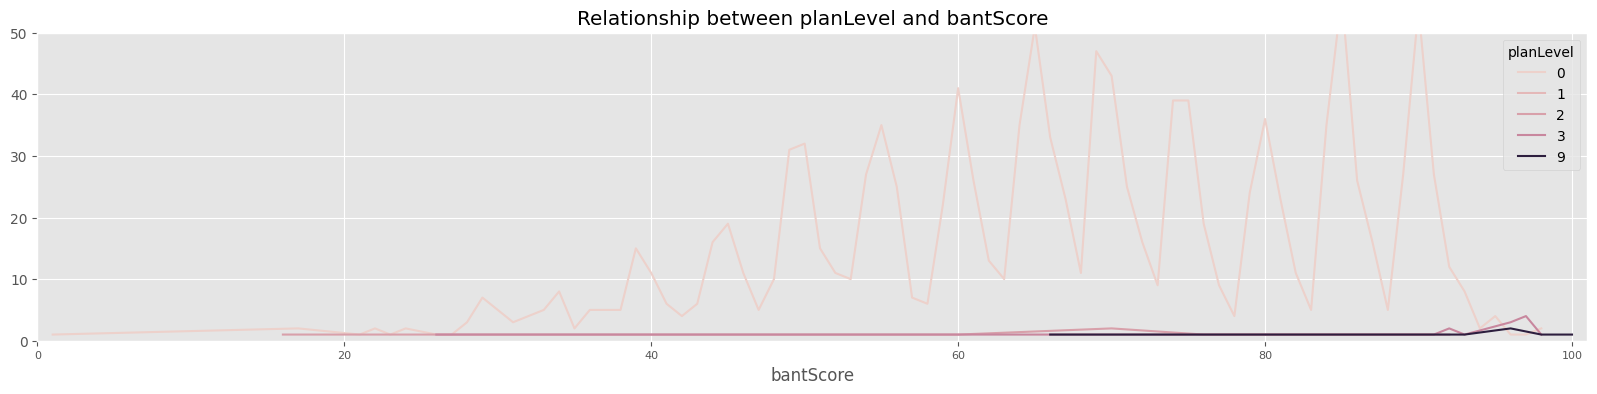

In [403]:
# Lineplot showing bantScore and planLevel
plt.figure(figsize=(20,4))
sns.lineplot(data=df, x = 'bantScore', y = bant_df['bantScore'].count(),hue = 'planLevel', estimator=lambda x: len(x))
plt.xlim(0, 101)  
plt.ylim(0, 50)
plt.title('Relationship between planLevel and bantScore')

plt.xticks(fontsize= 8)
plt.show()

## Encoding

#### Label encoding for correlation 

In [404]:
# Using labelEncoder for the correlation heatmaps
df_corr = df_no_bant
columns_to_encode = ['role', 'country', 'top_industry']

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Loop through each column and label encode the values
for column in columns_to_encode:
    df_corr[column] = label_encoder.fit_transform(df_no_bant[column])


df_corr.head(1)

,created,lastActive,planLevel,num_sub_user,role,industry_categories,onboarding_stage,country,time_spent,top_industry
brand_id,,,,,,,,,,
2,2020-08-28 04:38:11,2021-01-07 21:10:32,0,1,76,[],4,82,3184.539167,46


#### One Hot Encoding for ML

In [405]:
# Using One Hot Encoding for Classification
df_stats = df_no_bant.copy()
df_no_bant = pd.get_dummies(df_no_bant, columns = ['role', 'country', 'top_industry'])


## Correlation

In [406]:
# Dropping industry categories from each dataframe 
df_no_bant = df_no_bant.drop(['industry_categories'], axis = 1)
df_corr = df_corr.drop(['industry_categories'], axis = 1)

<Axes: >

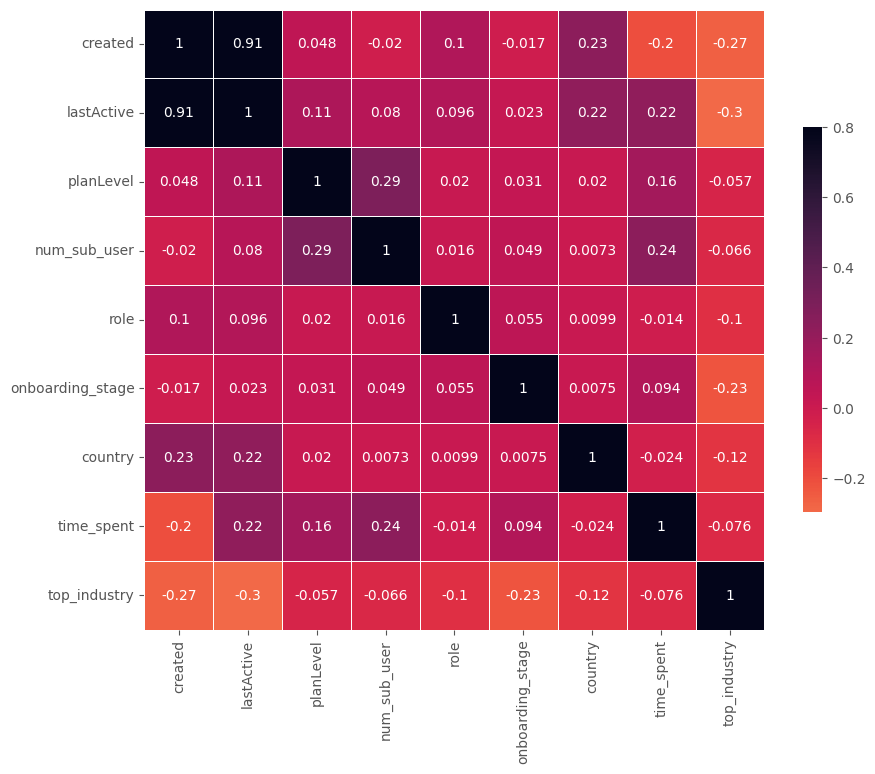

In [407]:
# Heat map of correlation 
plt.figure(figsize = (10,10))
sns.heatmap(df_corr.corr(), cbar = True, annot = True, cmap= 'rocket_r', vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<Axes: >

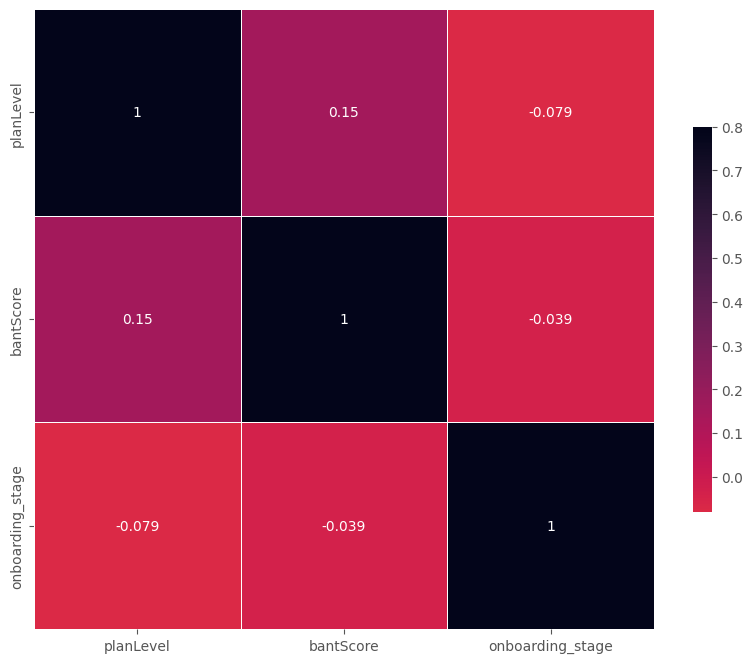

In [408]:
# Correlation heatmap of bantScore and onboarding_stage
df_all = df[['planLevel', 'bantScore', 'onboarding_stage']]
df_all = df_all.dropna()
df_all.isnull().sum()
plt.figure(figsize = (10,10))
sns.heatmap(df_all.corr(), cbar = True, annot = True, cmap= 'rocket_r', vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

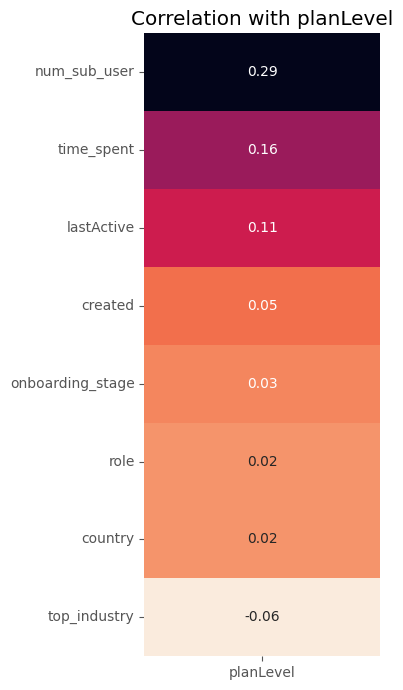

In [409]:
# Compute the correlation matrix
corr = df_corr.corr()

# Create a subplot for each disease
fig, ax = plt.subplots(figsize=(4, 7))


target_corr = corr['planLevel'].drop('planLevel')
target_corr_sorted = target_corr.sort_values(ascending=False)

# Plot a heatmap of the correlations with the planLevel
sns.heatmap(target_corr_sorted.to_frame(), cmap="rocket_r", annot=True, fmt='.2f', cbar=False, ax=ax)
ax.set_title('Correlation with planLevel')

plt.tight_layout()
plt.show()

## Machine Learning 

In [410]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
from sklearn.metrics import balanced_accuracy_score
import shap

In [411]:
# Define the features and target
df_no_bant = df_no_bant.drop(['created', 'lastActive'], axis = 1)
df_no_bant['planLevel'] = df_no_bant['planLevel'].replace(9, 4)
X = df_no_bant.drop('planLevel', axis=1)
y = df_no_bant['planLevel']


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Using SMOTE to handle class imbalance 
smote = SMOTE(sampling_strategy='not majority', k_neighbors = 1)
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train = pd.DataFrame(X_train, columns=X_train.columns)
y_train = pd.Series(y_train)


In [412]:
print(y_train.value_counts())

print(y_test.value_counts())

planLevel
0    3808
4    3808
1    3808
2    3808
3    3808
Name: count, dtype: int64
planLevel
0    948
3      7
4      3
2      3
1      1
Name: count, dtype: int64


In [413]:
# Instantiating XGB model
xgb_model = XGBClassifier(objective='multi:softmax')

# Defining pipeline and parameters
pipeline = Pipeline(steps = [('classifier', xgb_model)])

param_grid = {
    'classifier__max_depth': [4, 5],
    'classifier__learning_rate': [.4],
    'classifier__n_estimators': [100],
    'classifier__gamma': [.1],
    'classifier__reg_alpha' : [.15],
    'classifier__reg_lambda' : [.15],
    'classifier__min_child_weight' : [7]

}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring = 'balanced_accuracy', n_jobs = -1)

In [414]:
# Running the gridsearch
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constr...
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softmax',
                                                      predictor=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__gamma': [0.1],
                         'classifier__learning_rate': [0.4],
                         'classifier__max_depth': [4, 5],
                         'classifier__min_child_weight': [7],
                         'classifier__n_estimators': [100],
                         'classifier__reg_alpha': [0.15],
                         'classifier__reg_lambda': [0.15]},
             scoring='balanced_accuracy')

In [415]:
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
y_pred = grid_search.predict(X_test)
y_score = grid_search.predict_proba(X_test)
print(classification_report(y_test, y_pred))
bas = balanced_accuracy_score(y_test, y_pred)

print(bas)

Best Hyperparameters: {'classifier__gamma': 0.1, 'classifier__learning_rate': 0.4, 'classifier__max_depth': 4, 'classifier__min_child_weight': 7, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0.15, 'classifier__reg_lambda': 0.15}
Best Score: 0.9976886332046865
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       948
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.33      0.14      0.20         7
           4       0.20      0.33      0.25         3

    accuracy                           0.98       962
   macro avg       0.30      0.29      0.29       962
weighted avg       0.98      0.98      0.98       962

0.29397227245328506


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### Permutation Importance

In [416]:
# Getting most important features for classification
perm_imp = permutation_importance(grid_search, X_test, y_test, n_repeats = 10)

In [417]:
perm_data = {'importances_mean' : perm_imp['importances_mean'],
       'importances_std' : perm_imp['importances_std']}

perm_con = pd.DataFrame(perm_data, X_train.columns)
perm_con.sort_values('importances_mean', ascending = False, inplace = True)

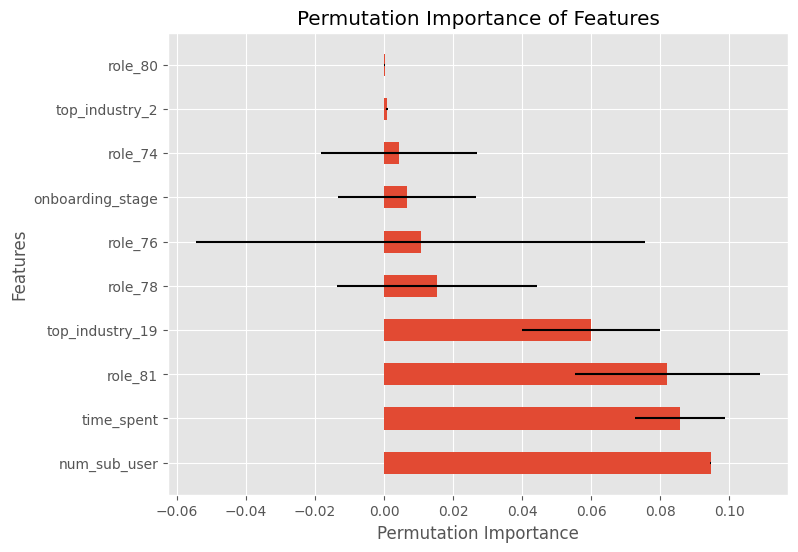

In [418]:
# Visualizing permutation importance with stds
plt.figure(figsize=(8, 6))
perm_con = perm_con.iloc[:10]
plt.barh(perm_con.index, perm_con['importances_mean'], xerr=perm_con['importances_std'], height=0.5)
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Importance of Features')
plt.show()

## Statistical Analysis 

### Num Sub User and PlanLevel 

In [419]:
# Num sub user and plan level (Chi square)
contingency = pd.crosstab(df['planLevel'], df['num_sub_user'], margins = False)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f'''Due to a chi2 value of {chi2} and a p-value of {p_value} we can reject the null hypothesis. 
this indicates a significant association between num_sub_users and planLevel.''')

Due to a chi2 value of 1899.8880516833003 and a p-value of 0.0 we can reject the null hypothesis. 
this indicates a significant association between num_sub_users and planLevel.


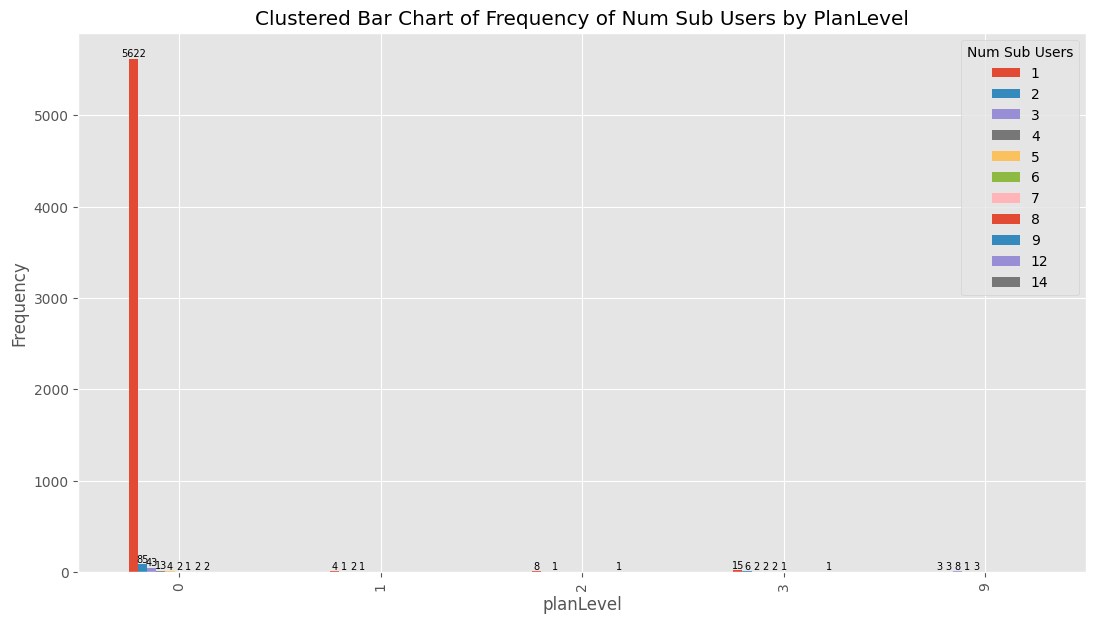

In [420]:

# Plotting data from contingency table
ax = contingency.plot(kind='bar',  figsize=(13, 7))
plt.xlabel('planLevel')
plt.ylabel('Frequency')
plt.title('Clustered Bar Chart of Frequency of Num Sub Users by PlanLevel')

# Adding labels on bars
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=7, color='black')
        
plt.legend(title='Num Sub Users')
plt.show()

### Plan level and time spent 

In [421]:
# plan level and time spent (ANOVA)
# Perform one-way ANOVA test
anova_result = stats.f_oneway(
    df_stats[df_stats['planLevel'] == 0]['time_spent'],
    df_stats[df_stats['planLevel'] == 1]['time_spent'],
    df_stats[df_stats['planLevel'] == 2]['time_spent'],
    df_stats[df_stats['planLevel'] == 3]['time_spent'],
    df_stats[df_stats['planLevel'] == 9]['time_spent']
)

print(f'''Due to a p-value of {anova_result.pvalue} we can reject the null hypothesis that the means of the groups are the same. 
Additionally an F-statistic of {anova_result.statistic} indicates that the variation between the groups is much larger than the variation within the groups.''')

Due to a p-value of 1.872220351955224e-27 we can reject the null hypothesis that the means of the groups are the same. 
Additionally an F-statistic of 33.318644811486045 indicates that the variation between the groups is much larger than the variation within the groups.


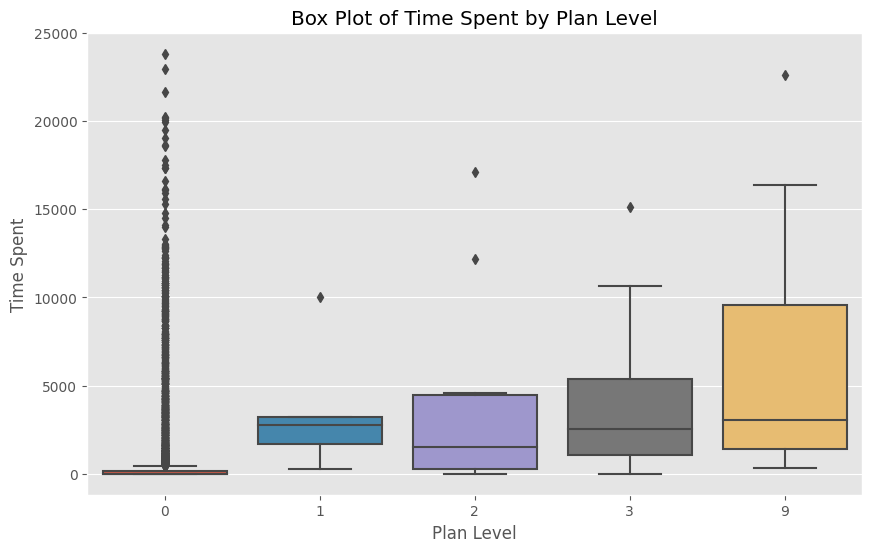

In [422]:
# Plotting boxplots for plan level and time spent 
plt.figure(figsize=(10, 6))
sns.boxplot(x='planLevel', y='time_spent', data=df_stats)
plt.xlabel('Plan Level')
plt.ylabel('Time Spent')
plt.title('Box Plot of Time Spent by Plan Level')
plt.show()

### Company size and plan level 

In [423]:
# Company size and plan level (chi square)
contingency = pd.crosstab(df['planLevel'], df['companySize'], margins = False)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f'''Due to a chi2 value of {chi2} and a p-value of {p_value} we can reject the null hypothesis.
This indicates a significant association between company size and Plan Level.''')

Due to a chi2 value of 119.29182822960286 and a p-value of 7.514630505670924e-18 we can reject the null hypothesis.
This indicates a significant association between company size and Plan Level.


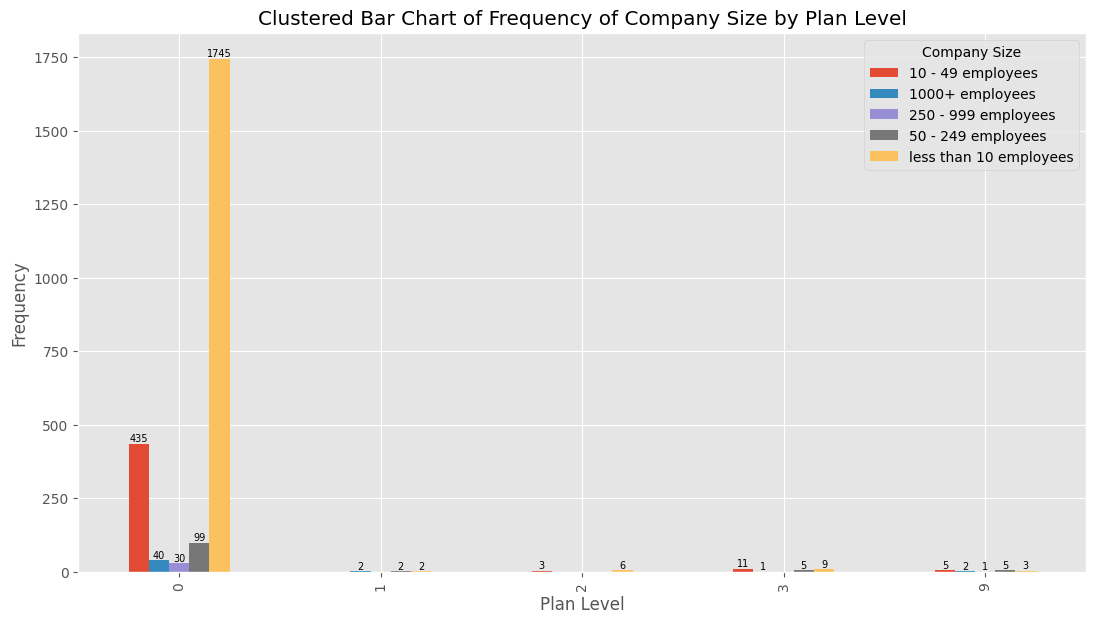

In [424]:

ax = contingency.plot(kind='bar',  figsize=(13, 7))
plt.xlabel('Plan Level')
plt.ylabel('Frequency')
plt.title('Clustered Bar Chart of Frequency of Company Size by Plan Level')

for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=7, color='black')
        
plt.legend(title='Company Size')
plt.show()

### Bant score and plan level 

In [425]:
contingency = pd.crosstab(df['bantScore'], df['planLevel'], margins = False)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f'''Due to a chi2 value of {chi2} and a p-value of {p_value} we can reject the null hypothesis.
This indicates a significant association between Bant Score and Plan Level.''')

Due to a chi2 value of 1029.998365101719 and a p-value of 1.3913701361271242e-77 we can reject the null hypothesis.
This indicates a significant association between Bant Score and Plan Level.


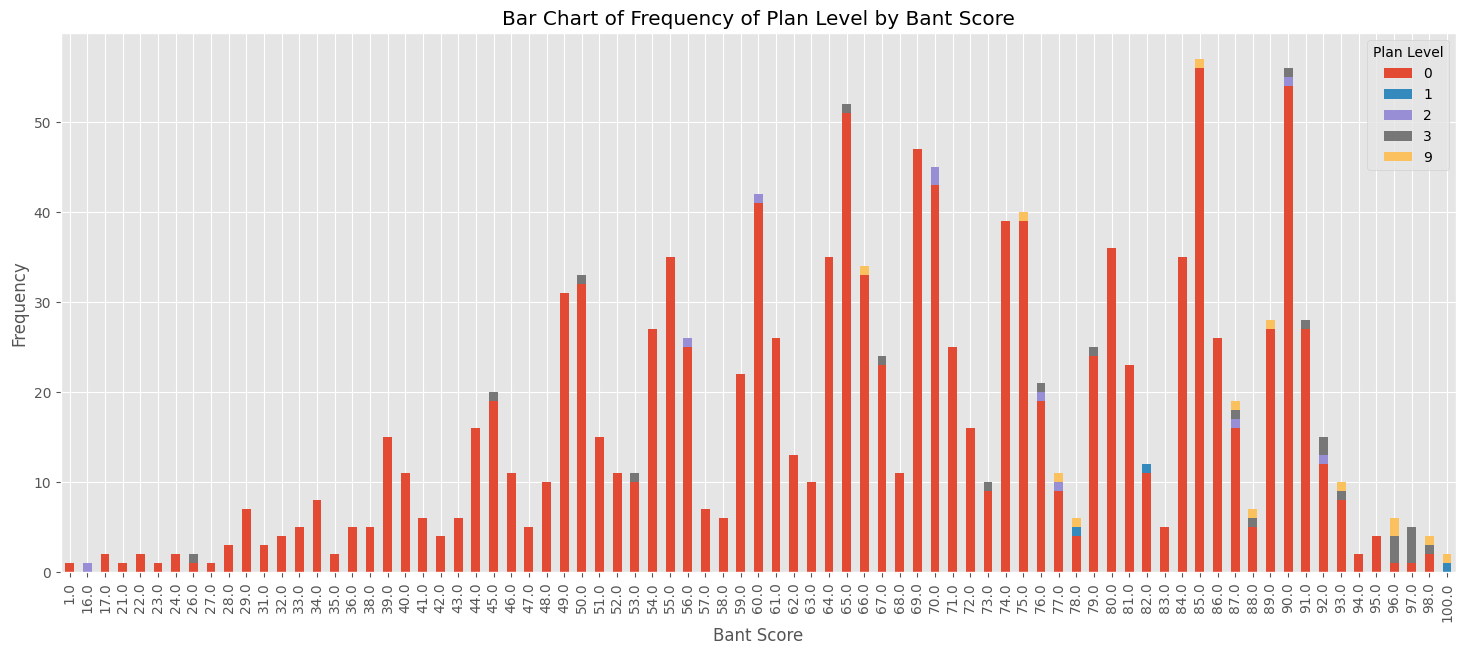

In [426]:
ax = contingency.plot(kind='bar', stacked = True, figsize=(18, 7))
plt.xlabel('Bant Score')
plt.ylabel('Frequency')
plt.title('Bar Chart of Frequency of Plan Level by Bant Score')


        
plt.legend(title='Plan Level')
plt.show()

### Role and Onboarding Stage

In [427]:
# Role and onboarding stage (chi square)
contingency = pd.crosstab(df['role'], df['onboarding_stage'], margins = False)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f'''Due to a chi2 value of {chi2} and a p-value of {p_value} we can reject the null hypothesis.
This indicates there is a significant association between Role and Onboarding Stage.''')

Due to a chi2 value of 1649.8171321710086 and a p-value of 1.0612628844083832e-126 we can reject the null hypothesis.
This indicates there is a significant association between Role and Onboarding Stage.


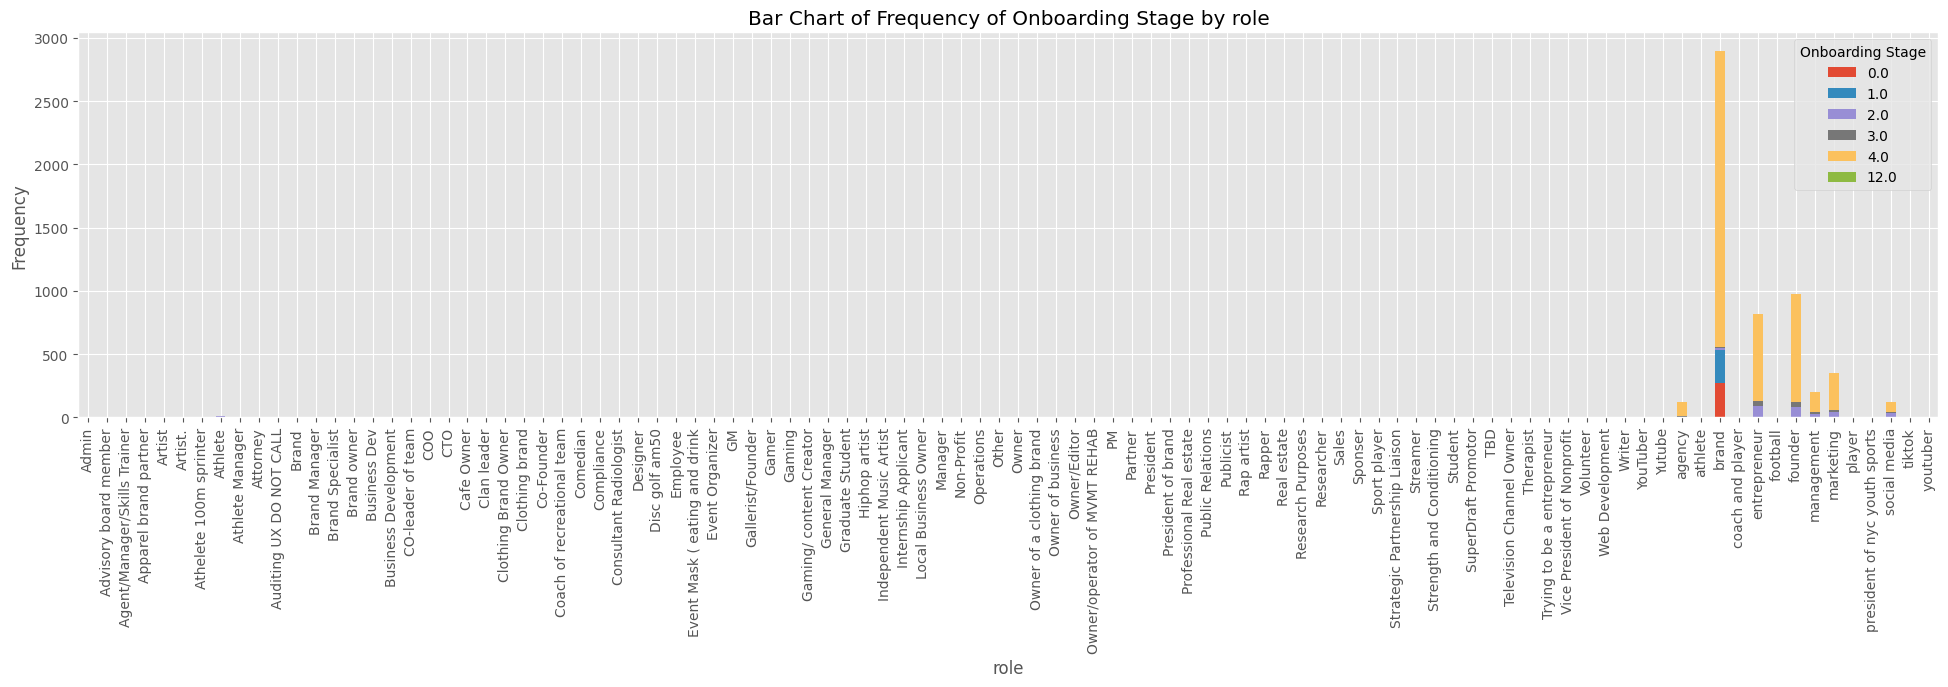

In [428]:
ax = contingency.plot(kind='bar', stacked = True, figsize=(24, 5))
plt.xlabel('role')
plt.ylabel('Frequency')
plt.title('Bar Chart of Frequency of Onboarding Stage by role')
        
plt.legend(title='Onboarding Stage')
plt.show()

### Num sub user and top industry

In [429]:
# Num sub user and top industry (chi square) 
contingency = pd.crosstab(df_total['top_industry'], df_total['num_sub_user'], margins = False)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f'''Due to a chi2 value of {chi2} and a p-value of {p_value} we can reject the null hypothesis.
This indicates a significant association between Num Sub User and Top Industry.''')

Due to a chi2 value of 2393.0766229141423 and a p-value of 0.0 we can reject the null hypothesis.
This indicates a significant association between Num Sub User and Top Industry.


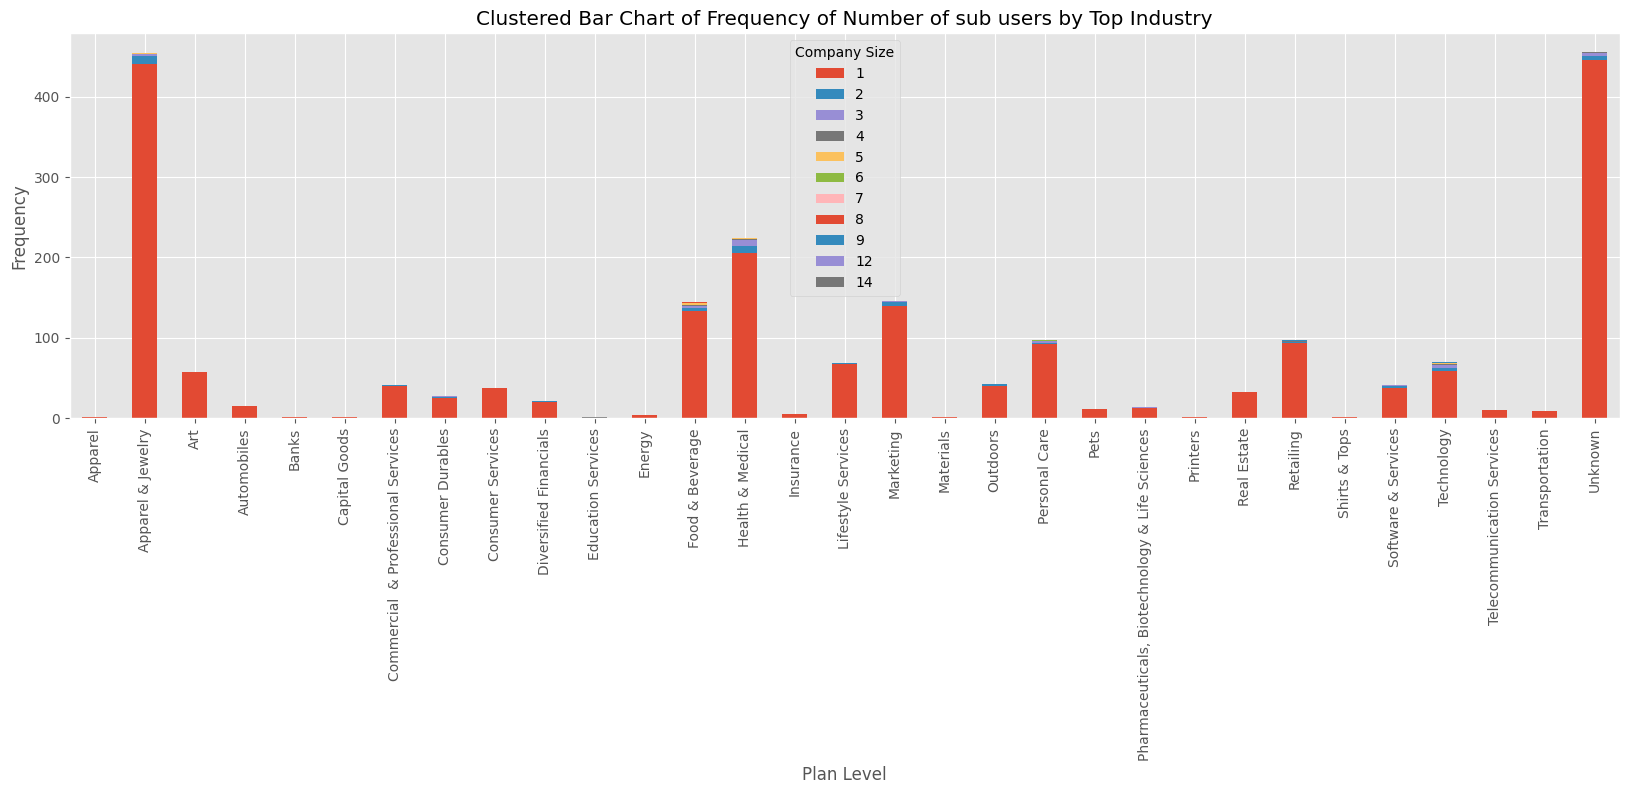

In [430]:
ax = contingency.plot(kind='bar', stacked = True,  figsize=(20, 5))
plt.xlabel('Plan Level')
plt.ylabel('Frequency')
plt.title('Clustered Bar Chart of Frequency of Number of sub users by Top Industry')

# for p in ax.patches:
#     height = int(p.get_height())
#     if height > 0:
#         ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=7, color='black')
        
plt.legend(title='Company Size')
plt.show()

In [431]:
# Role and onboarding stage (chi square)
contingency = pd.crosstab(df['planLevel'], df['onboarding_stage'], margins = False)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f'''Due to a chi2 value of {chi2} and a p-value of {p_value} we fail to reject the null hypothesis.
This indicates there is not a significant association between Plan Level and Onboarding Stage.''')

Due to a chi2 value of 12.509347539082283 and a p-value of 0.8974304394025071 we fail to reject the null hypothesis.
This indicates there is not a significant association between Plan Level and Onboarding Stage.


## Conclusion

- **Num Sub Users**:
Based on the initial correlation value to planLevel of .29 and a permutation importance mean of .09. It seems that number of sub users on a brands account is a strong indicator of whether or not that user subscribes to the service. This is further supported by our chi-squared test for independence that showed us that planLevel and num_sub_users are highly dependent with a p-value of 0.0. Based on the data it seems that we want to encourage brands to add up to 3 sub users on to their account. 
- **Time Spent**:
Based on the initial correlation value to planLevel of .16 and a permutation importance mean of ~.88. We can see that the time a brand spends on the site the more likely they are to subscribe to a paid subscription. This is further supported by the boxplot showing that as plan level goes up so does time spent on the site. This was confirmed by the ANOVA test that showed a p-value of 1.8e-27, and an f-statistic of 33.3. 

### What’s the limitation of the data set? What additional data points do you think that can be added to this study? Why?

The two biggest limitations of this dataset are the amount of missing values and the class imbalance in planLevel. If more data for all of the paid plan levels were added to this data it would enable me to create a better classification model for predicting whether a client subscribes or not. It would also allow for more reliable statical analysis. Depending on the types of questions asked in the onboarding stage it would be interesting to see that data included. It would be helpful for finding trends for the motivations of users that subscribe to a paid plan level.